In [47]:
# NN 4 outputs and with and without sorting of outputs
model_path = 'saved_model/Multi_leak/experiment5/Mask_MTL_sameLoss/'
project_name='Multi_leak_experiment5_Mask_MTL_withSwap_sameloss'

In [48]:
# Experiment 2 - 1 output layer with 1 loss function - mse. and do hyper parameter tuning.
from utils.data_preprocess import load_data
import pandas as pd 
import yaml
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from kerastuner import HyperModel, Hyperband
from keras import backend as backend

In [65]:
single_leakage, two_leakage = load_data()
# two_leakage["leak_1"] = 1
two_leakage["leak_2"] = 1

# single_leakage["leak_1"] = 1
single_leakage["leak_2"] = 0

data = pd.concat([single_leakage, two_leakage], axis=0)
data['x2'] = data['x2'].replace(np.nan, 0)
data['y2'] = data['y2'].replace(np.nan, 0)

data = data.drop(columns=['mfc6_residual',
       'mfc7_residual', 'mfc8_residual', 'mfc9_residual', 'mfc10_residual',
       'mfc1_residual', 'mfc2_residual', 'mfc3_residual', 'mfc4_residual',
       'mfc5_residual', 'total flow rate'
       ])

y = data[['x1', 'y1', 'x2', 'y2', "leak_2"]]
x = data.drop(['x1', 'y1', 'x2', 'y2', "leak_2"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 


# sort x1, y1 and x2, y2. coordinates with lowest x will take the position of x1
def coords_swap(y1):
    s = y1['x2'] < y1['x1']
    y1.loc[s, ['x1','x2']] = y1.loc[s, ['x2','x1']].values
    y1.loc[s, ['y1','y2']] = y1.loc[s, ['y2','y1']].values
    return y1

y1_test_unsc = y_test

y1_data = [y_train, y_val, y_test]
y1_data_types = ['y_train', 'y_val', 'y_test']
for y1_data_types, y1 in zip(y1_data_types, y1_data):
    y1_data_types = coords_swap(y1)

y1_train = y_train[['x1', 'y1']]
y1_test = y_test[['x1', 'y1']]
y1_val = y_val[['x1', 'y1']]

y2_train = y_train[['x2', 'y2']]
y2_test = y_test[['x2', 'y2']]
y2_val = y_val[['x2', 'y2']]


y3_train = y_train[["leak_2"]]
y3_test = y_test[["leak_2"]]
y3_val = y_val[["leak_2"]]

y1_columns = y1_train.columns
y2_columns = y2_train.columns
y3_columns = y3_train.columns
X_columns = X_train.columns

scaler_coords1 = StandardScaler()
y1_train = scaler_coords1.fit_transform(y1_train)
y1_test = scaler_coords1.transform(y1_test)
y1_val = scaler_coords1.transform(y1_val)

y1_train = pd.DataFrame(y1_train, columns=y1_columns)
y1_test = pd.DataFrame(y1_test, columns=y1_columns)
y1_val = pd.DataFrame(y1_val, columns=y1_columns)

scaler_coords2 = StandardScaler()
y2_train = scaler_coords2.fit_transform(y2_train)
y2_test = scaler_coords2.transform(y2_test)
y2_val = scaler_coords2.transform(y2_val)

y2_train = pd.DataFrame(y2_train, columns=y2_columns)
y2_test = pd.DataFrame(y2_test, columns=y2_columns)
y2_val = pd.DataFrame(y2_val, columns=y2_columns)

scaler_flows = StandardScaler()
X_train = scaler_flows.fit_transform(X_train)
X_test = scaler_flows.transform(X_test)
X_val = scaler_flows.transform(X_val)

X_train = pd.DataFrame(X_train, columns=X_columns)
X_test = pd.DataFrame(X_test, columns=X_columns)
X_val = pd.DataFrame(X_val, columns=X_columns)

# y_train = [y1_train, y2_train]
# y_val = [y1_val, y2_val]
# y_test = [y1_test, y2_test]

y3_train = y3_train.reset_index().drop(columns='sample_number')
y3_val = y3_val.reset_index().drop(columns='sample_number')
y3_test = y3_test.reset_index().drop(columns='sample_number')

y_train_all = pd.concat([y1_train, y2_train, y3_train], axis=1)
y_test_all = pd.concat([y1_test, y2_test, y3_test], axis=1)
y_val_all = pd.concat([y1_val, y2_val, y3_val], axis=1)

In [50]:
X_train_np, y1_train_np, y2_train_np, y3_train_np = X_train.values, y1_train.values, y2_train.values, y3_train.values
X_val_np, y1_val_np, y2_val_np, y3_val_np = X_val.values, y1_val.values, y2_val.values, y3_val.values
X_test_np, y1_test_np, y2_test_np, y3_test_np = X_test.values, y1_test.values, y2_test.values, y3_test.values

# Create TensorFlow datasets from NumPy arrays.
batch_size = 32
buffer_size = len(X_train)  # Set the buffer size to the number of training examples for full shuffling.

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y1_train_np, y2_train_np , y3_train_np))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y1_val_np, y2_val_np, y3_val_np))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_np, y1_test_np, y2_test_np, y3_test_np))

# Shuffle, batch, and prefetch the training dataset.
train_dataset_org = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Batch the validation and test datasets.
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [51]:
def masked_mse(y_true, y_pred):
    mask = tf.keras.backend.cast(tf.keras.backend.not_equal(y_true, 0), tf.keras.backend.floatx())
    mse = tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred) * mask)
    return mse

losses = {
	"y1": "mse",
	"y2": masked_mse,
    "y3": 'mse'
    }

metrics = {
    "y1": 'mae',
    "y2": 'mae',
    "y3": 'mae'
    }

In [52]:
EPOCHS = 1000

# Define custom loss function


# Define model builder function for Keras Tuner
def model_builder(hp):
    tf.keras.backend.clear_session()
    # Tune the number of units in the first Dense layer
    # Define model
    inputs = tf.keras.Input(shape=(10,))
    shared_layer = inputs
    for i in range(hp.Int('num_layers', 1, 15)):
        shared_layer = layers.Dense(
            units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
            activation='relu',
            # add elu
            kernel_initializer='he_uniform'
        )(shared_layer)

    task_layer1 = shared_layer
    for j in range(hp.Int(f'task_{i}_num_layers', 0, 10)):
        task_layer1 = layers.Dense(units=hp.Int(f'task_{i}_layer_{j}_neurons', min_value=8, max_value=256, step=8), 
                                    activation='relu',
                                    kernel_initializer='he_uniform')(task_layer1)
    out1 = layers.Dense(2, name='y1', activation = 'linear', kernel_initializer='he_uniform')(task_layer1)
    out2 = layers.Dense(2, name='y2', activation = 'linear', kernel_initializer='he_uniform')(task_layer1)

    task_layer2 = shared_layer
    for j in range(hp.Int(f'task_{i}_num_layers', 0, 10)):
        task_layer2 = layers.Dense(units=hp.Int(f'task_{i}_layer_{j}_neurons', min_value=2, max_value=64, step=2),
                                    activation='relu',
                                    kernel_initializer='he_uniform')(task_layer2)
    out3 = layers.Dense(1, name='y3', activation = 'sigmoid', kernel_initializer='he_uniform')(task_layer2)

    model = tf.keras.Model(inputs=inputs, outputs=[out1, out2, out3])

    # loss1_weight = hp.Choice('loss1_weight', values=[0.6, 0.7, 0.8, 0.9])
    # loss2_weight = 1 - loss1_weight
    loss1_weight = 0.9
    loss2_weight = 0.1

    lossWeights = {"y1": loss1_weight, "y2": loss1_weight, "y3": loss2_weight}

    # Tune the learning rate for the optimizer
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")

    # model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=['mse', masked_mse])
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate),
                    loss=losses, 
                    loss_weights=lossWeights,
                    metrics = metrics)
    
    return model

tuner = Hyperband(
    model_builder,
    objective =  kt.Objective("val_loss", direction="min"),
    max_epochs=EPOCHS+100,
    factor=2,
    directory="../../tensorflow_log_files/studienarbeit/",
    project_name=project_name,
    seed = 0
)

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform hyperparameter search
tuner.search(train_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})),
            #  X_train, y_train, 
            #  validation_data = (X_val, y_val), 
            validation_data = val_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})), 
             verbose = 1, callbacks=[stop_early],
             epochs=EPOCHS, shuffle = True)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps)

# Build the best model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model on the full dataset
history = best_model.fit(train_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})),
            #  X_train, y_train,
            #  validation_data = (X_val, y_val), 
            validation_data = val_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})), 
            # callbacks=[stop_early],
            verbose = 1, epochs=EPOCHS, shuffle = True)

print(f"""
    The hyperparameter search is complete. The optimal learning rate for the optimizer
    is {best_model.optimizer.lr.numpy()}.
    """)

INFO:tensorflow:Reloading Tuner from ../../tensorflow_log_files/studienarbeit/Multi_leak_experiment5_Mask_MTL_withSwap_sameloss/tuner0.json
Search space summary
Default search space size: 182
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 15, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
task_0_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 

In [53]:
best_model.save(model_path)
# best_model = tf.keras.models.load_model(model_path)
best_model.summary()

INFO:tensorflow:Assets written to: saved_model/Multi_leak/experiment5/Mask_MTL_sameLoss/assets
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 160)          1760        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 512)          82432       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 416)          213408      ['dense_1[0][0]']                

In [54]:
# tuner.results_summary()

In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
y_predictions_train = best_model.predict(train_dataset_org.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})))
# print("train", "{:10.4f}".format(mean_squared_error(y_train, y_predictions, squared=True)))
y_predictions_val = best_model.predict(val_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})))
# print("val", "{:10.4f}".format(mean_squared_error(y_val, y_predictions, squared=True)))
y_predictions = best_model.predict(test_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})))

y_predictions_train = np.concatenate((y_predictions_train[0], y_predictions_train[1], y_predictions_train[2]), axis=1)
y_predictions_val = np.concatenate((y_predictions_val[0], y_predictions_val[1], y_predictions_val[2]), axis=1)
y_predictions = np.concatenate((y_predictions[0], y_predictions[1], y_predictions[2]), axis=1)

y_predictions_train[:,-1][np.abs(y_predictions_train[:,-1]) < 0.5] = 0
y_predictions_train[:,-1][np.abs(y_predictions_train[:,-1]) > 0.5] = 1

y_predictions_val[:,-1][np.abs(y_predictions_val[:,-1]) < 0.5] = 0
y_predictions_val[:,-1][np.abs(y_predictions_val[:,-1]) > 0.5] = 1

y_predictions[:,-1][np.abs(y_predictions[:,-1]) < 0.5] = 0
y_predictions[:,-1][np.abs(y_predictions[:,-1]) > 0.5] = 1

loss_test = "{:10.4f}".format(mean_squared_error(y_test_all, y_predictions, squared=True))
metric_test = "{:10.4f}".format(mean_absolute_error(y_test_all, y_predictions))

loss_val = "{:10.4f}".format(mean_squared_error(y_val_all, y_predictions_val, squared=True))
metric_val = "{:10.4f}".format(mean_absolute_error(y_val_all, y_predictions_val))

loss_train = "{:10.4f}".format(mean_squared_error(y_train_all, y_predictions_train, squared=True))
metric_train = "{:10.4f}".format(mean_absolute_error(y_train_all, y_predictions_train))

print(metric_test, metric_val, metric_train)

4/4 [==============================] - 0s 2ms/step
    0.0941     0.0909     0.0285


In [56]:
results_train = best_model.evaluate(train_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})), verbose=1)
results_val = best_model.evaluate(val_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})), verbose=1)
results_test = best_model.evaluate(test_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})), verbose=1)

4/4 [==============================] - 0s 4ms/step - loss: 0.0553 - y1_loss: 0.0239 - y2_loss: 0.0366 - y3_loss: 0.0085 - y1_mae: 0.0941 - y2_mae: 0.1368 - y3_mae: 0.0085


In [63]:
coords1 = y_predictions[:,:2]
coords2 = y_predictions[:,2:4]

predictions1_unsc = scaler_coords1.inverse_transform(coords1)
predictions2_unsc = scaler_coords2.inverse_transform(coords2)

predictions1_unsc = pd.DataFrame(predictions1_unsc, columns=y1_columns)
predictions2_unsc = pd.DataFrame(predictions2_unsc, columns=y2_columns)

predictions_unsc = pd.concat([predictions1_unsc, predictions2_unsc], axis=1)

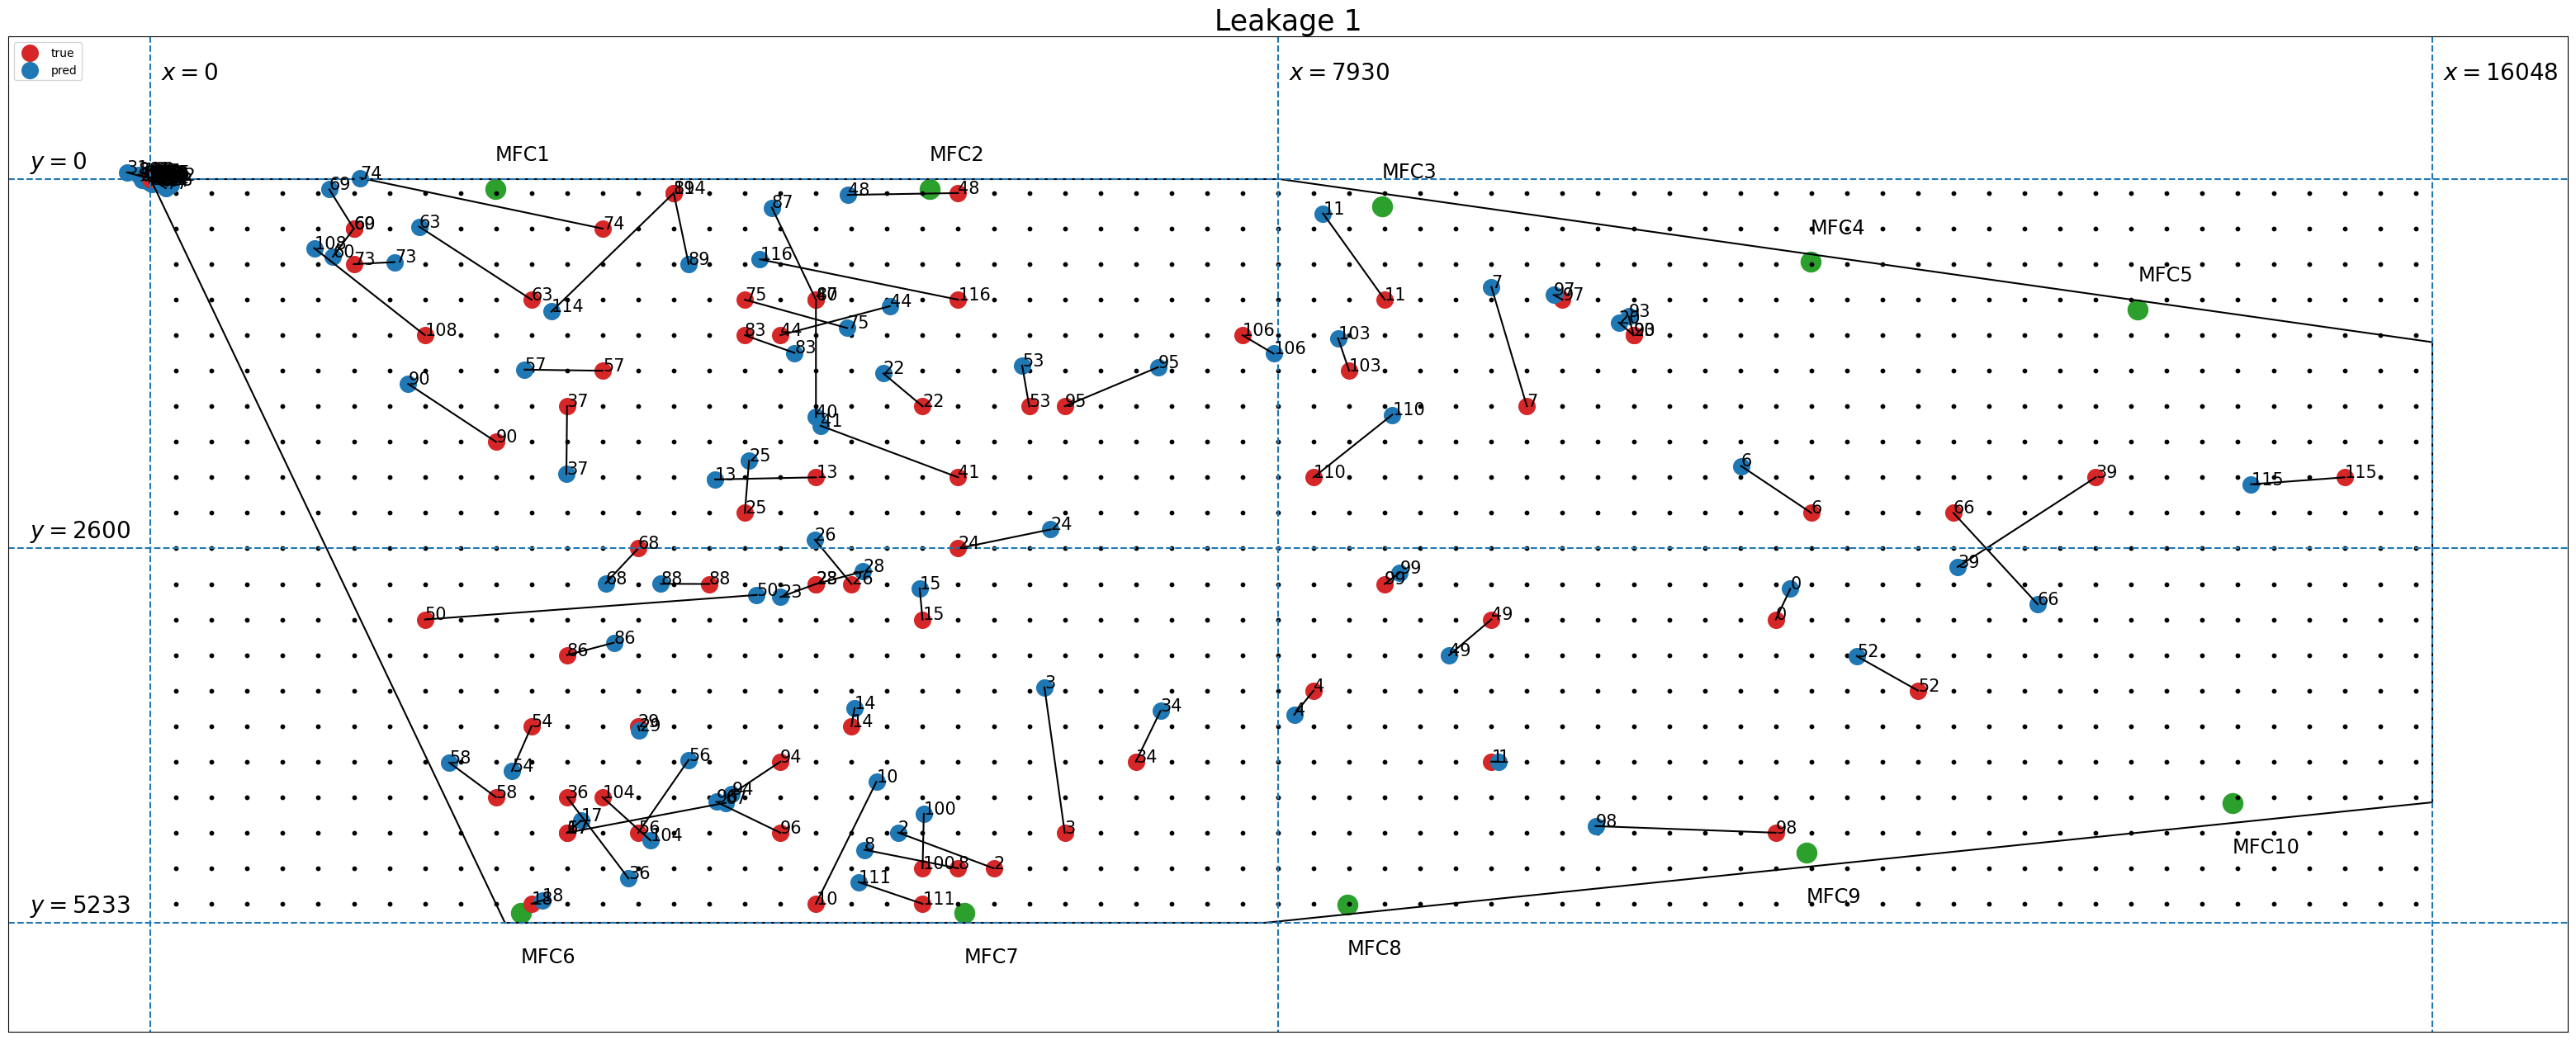

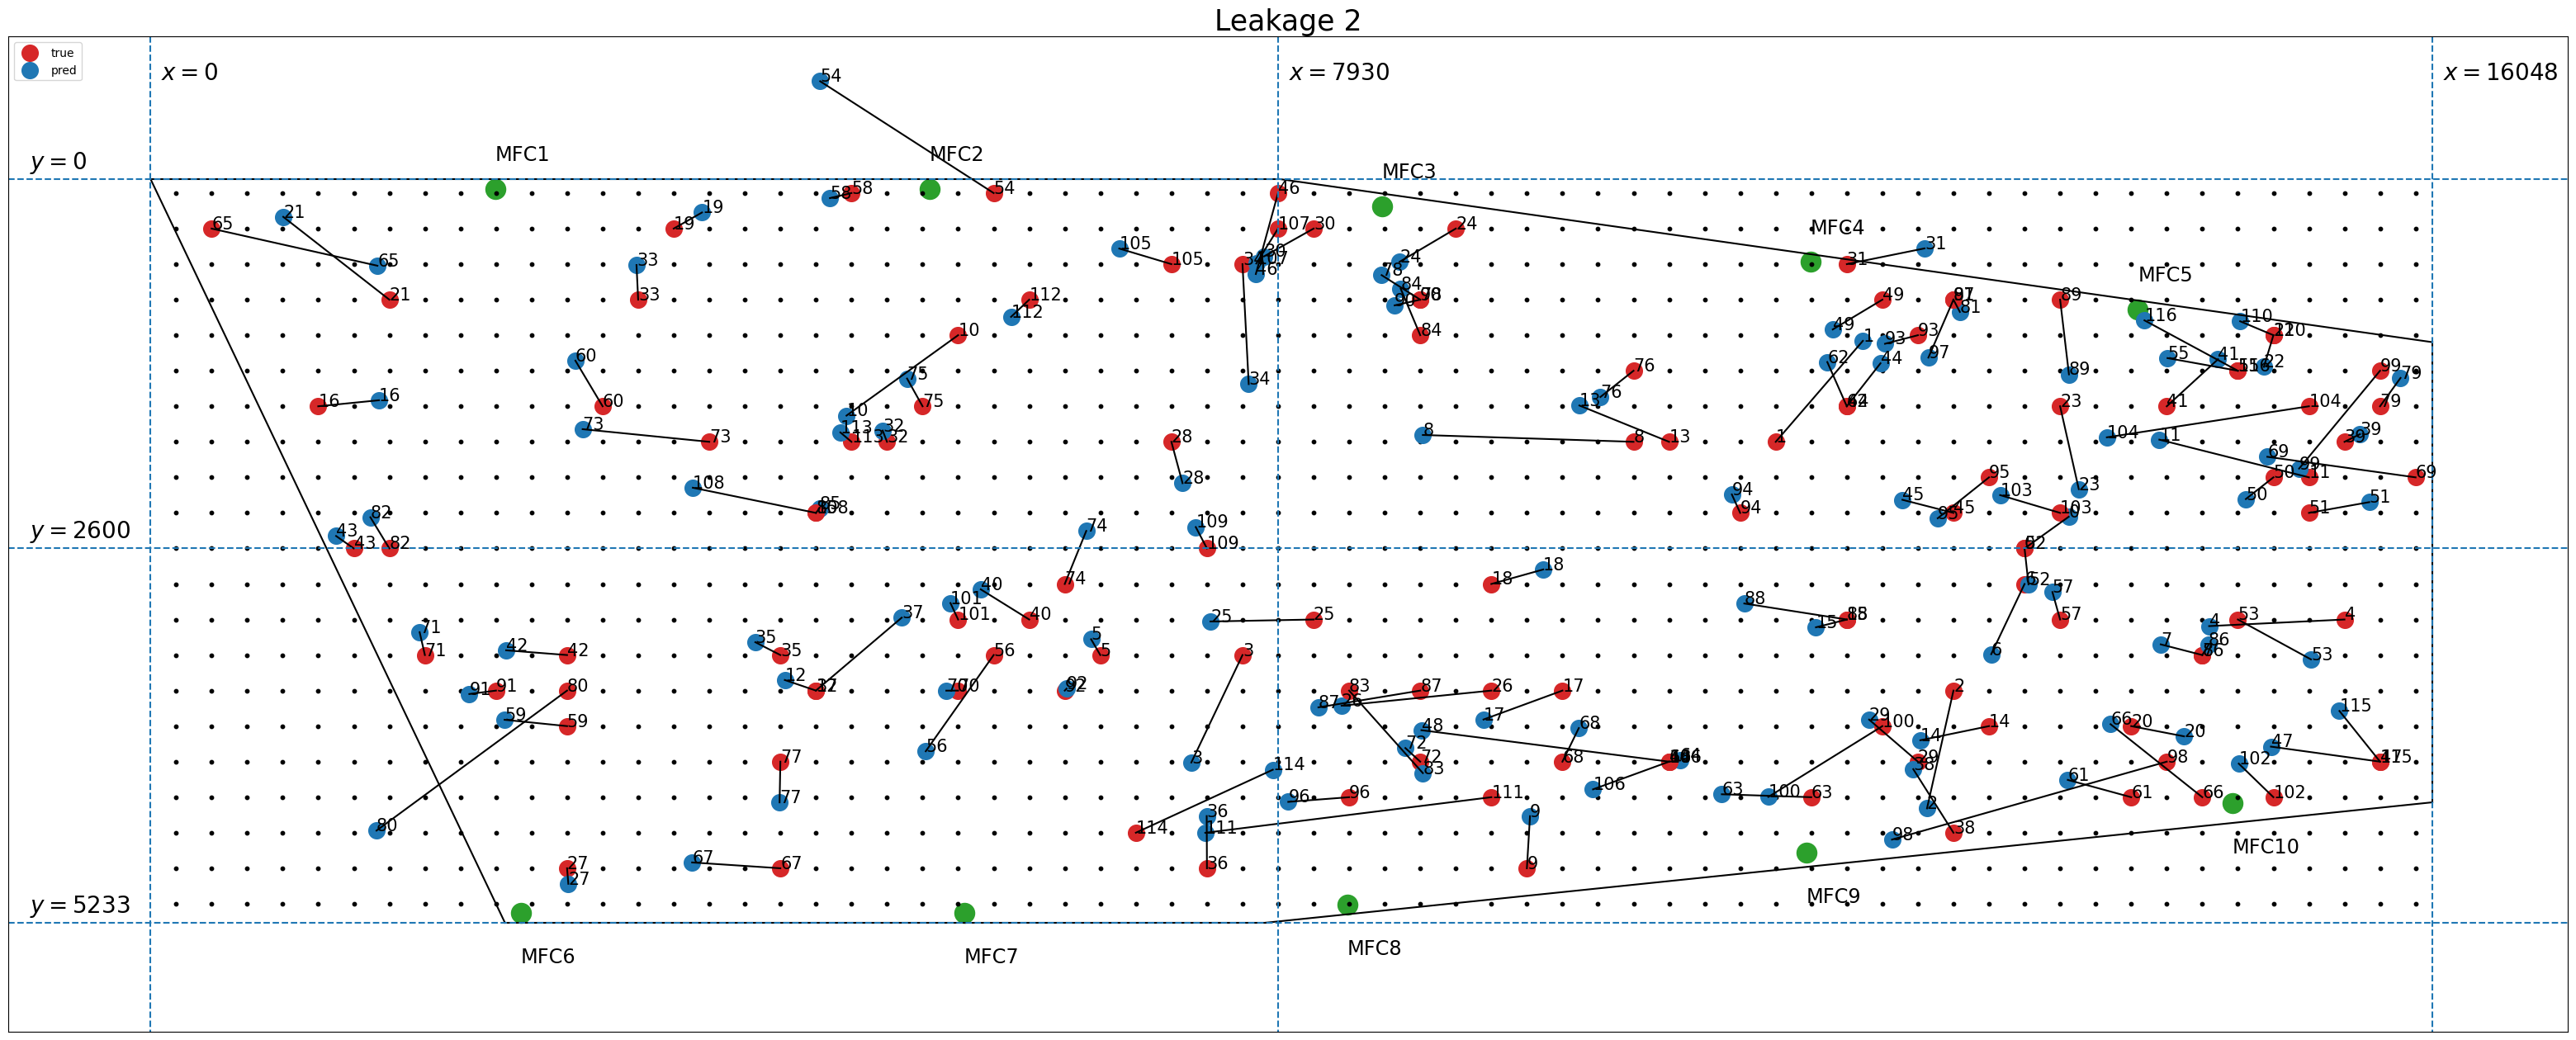

In [66]:
# predictions_unsc = scaler_coords1.inverse_transform(y_predictions)
y1_test_unsc = y1_test_unsc.reset_index().drop(columns='sample_number')

x_range = np.arange(180, 16048, 250)
y_range = np.arange(100, 5233, 250)
X, Y = np.meshgrid(x_range, y_range)


def plot_test_pred(test, pred, title):
    plt.figure(figsize=(40, 20))
    
    # plt.title(f'Sample Number {sample_number}', fontsize=20)
    
    # plot sensor positions
    sensors = np.array([[2426, 70], [5480, 70], [8661, 191], [11676, 584], [13976, 917], [2603, 5163], [5723, 5163], [8417, 5103], [11646, 4740], [14641, 4391]])
    for i in range(len(sensors)):
        plt.scatter(sensors[i, 0], sensors[i, 1], color='tab:green', s=300)
        if i < 5:
            plt.text(sensors[i, 0], sensors[i, 1] - 200, 'MFC'+str(i+1), fontsize='xx-large')
        else:
            plt.text(sensors[i, 0], sensors[i, 1] + 350, 'MFC'+str(i+1), fontsize='xx-large')

    # plot leakage positions
    plt.scatter(X, Y, color='black', s=10)
    
    for i in range(len(test)):
        if i != len(test)-1:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200)
            plt.scatter(pred[i][0], pred[i][1], color='tab:blue', s=200)
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)
        else:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200, label="true")
            plt.scatter(pred[i][0], pred[i][1], color='tab:blue', s=200, label="pred")
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)

    # print(X.shape)

    # plot wing contour
    plot_wing_contour()
    plt.title(title, fontsize = 25)

    # include grid coordinate system
    plt.hlines(0, -1000, 17000, linestyle='dashed')
    plt.hlines(2600, -1000, 17000, linestyle='dashed')
    plt.hlines(5233, -1000, 17000, linestyle='dashed')
    plt.vlines(0, -1000, 6000, linestyle='dashed')
    plt.vlines(7930, -1000, 6000, linestyle='dashed')
    plt.vlines(16048, -1000, 6000, linestyle='dashed')
    plt.text(-850, -75, '$y = 0$', fontsize=20)
    plt.text(-850, 2600-75, '$y = 2600$', fontsize=20)
    plt.text(-850, 5233-75, '$y = 5233$', fontsize=20)
    plt.text(75, -700, '$x=0$', fontsize=20)
    plt.text(7930+75, -700, '$x=7930$', fontsize=20)
    plt.text(16048+75, -700, '$x=16048$', fontsize=20)
    # plt.text(180, 5800, f'(x1, y1) = ({x1}, {y1}) = ({j1-31}, {-i1+10})', fontsize=20)
    plt.legend(loc="upper left")
    # invert y axis
    plt.gca().invert_yaxis()
    # plt.savefig('./results/hypermodel_results.png')

def plot_multi_leak(test, pred):
    plot_test_pred(test[['x1', 'y1']].to_numpy(), pred[['x1', 'y1']].to_numpy(), 'Leakage 1')
    plot_test_pred(test[['x2', 'y2']].to_numpy(), pred[['x2', 'y2']].to_numpy(), 'Leakage 2')
    plt.show()

def plot_wing_contour():
    plt.plot([0, 7930], [0, 0], 'k')
    plt.plot([7930, 16048], [0, 1149], 'k')
    plt.plot([16048, 16048], [1149, 4386], 'k')
    plt.plot([16048, 7843], [4386, 5233], 'k')
    plt.plot([7843, 2493], [5233, 5233], 'k')
    plt.plot([2493, 0], [5233, 0], 'k')
    plt.xlim([-1000, 17000])
    plt.ylim([-1000, 6000])
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal')

plot_multi_leak(y1_test_unsc, predictions_unsc)